In [ ]:
import os
import datetime
import numpy as np
import wfdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────
# set this to your local MIT‑BIH folder
DATA_DIR    = r"C:/Users/arfao/Desktop/stage_2025/mit_dataset_project/mit-bih-arrhythmia-database-1.0.0"
WINDOW      = 300        # samples per beat
MIN_COUNT   = 2          # drop classes with fewer than MIN_COUNT examples
TEST_RATIO  = 0.3
SEED        = 42
BATCH_SIZE  = 64
NUM_EPOCHS  = 20
LR          = 1e-3

# ─── UTILITY FUNCTIONS ─────────────────────────────────
def map_label5(sym):
    # AAMI five‑class grouping
    if sym in ['N','L','R','e','j']:
        return 0  # Normal
    if sym in ['A','a','J','S']:
        return 1  # Supraventricular ectopic
    if sym in ['V','E']:
        return 2  # Ventricular ectopic
    if sym in ['F','f']:
        return 3  # Fusion
    return 4      # Other/unknown


def load_data(data_dir, window, test_ratio, seed, min_count):
    half = window // 2
    # gather record IDs
    recs = sorted(
        os.path.splitext(f)[0]
        for f in os.listdir(data_dir)
        if f.lower().endswith('.hea')
           and os.path.exists(os.path.join(data_dir, f.replace('.hea', '.dat')))
    )
    items = []  # (rec, idx, lbl)
    sig_cache = {}
    # index all beats
    for rec in recs:
        path = os.path.join(data_dir, rec)
        sigs, _ = wfdb.rdsamp(path)
        sig      = sigs[:,0].astype(np.float32)
        ann      = wfdb.rdann(path, 'atr')
        sig_cache[rec] = sig
        for idx, sym in zip(ann.sample, ann.symbol):
            if half <= idx < len(sig) - half:
                items.append((rec, idx, map_label5(sym)))

    if not items:
        raise ValueError(f"No beats found in {data_dir}")

    # drop rare classes
    labels = [lbl for _,_,lbl in items]
    unique, counts = np.unique(labels, return_counts=True)
    valid = set(unique[counts >= min_count])
    items = [(r,i,l) for (r,i,l) in items if l in valid]
    if not items:
        raise ValueError(f"All beats filtered out (min_count={min_count})")

    # build arrays
    X = np.stack([sig_cache[r][i-half:i+half] for r,i,_ in items])  # (N,window)
    y = np.array([lbl for _,_,lbl in items], dtype=np.int64)
    X = X[..., None]  # (N,window,1)

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_ratio,
        random_state=seed,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, unique, counts


def plot_history(history):
    try:
        import matplotlib.pyplot as plt
        epochs = range(1, len(history['train_loss'])+1)
        plt.figure()
        plt.plot(epochs, history['train_loss'], label='Train Loss')
        plt.plot(epochs, history['val_loss'],   label='Val Loss')
        plt.legend(); plt.title('Loss over Epochs'); plt.show()

        plt.figure()
        plt.plot(epochs, history['train_acc'], label='Train Acc')
        plt.plot(epochs, history['val_acc'],   label='Val Acc')
        plt.legend(); plt.title('Accuracy over Epochs'); plt.show()
    except ImportError:
        print('matplotlib not installed; skipping history plot')


def plot_confusion(y_true, y_pred, class_names):
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel('Predicted'); plt.ylabel('True');
        plt.title('Confusion Matrix'); plt.show()
    except ImportError:
        print('seaborn or matplotlib not installed; skipping confusion plot')
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred,
                                target_names=class_names,
                                zero_division=0))

# ─── DATASET & MODEL ───────────────────────────────────
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        # transpose: (window,1) -> (1,window)
        return (
            torch.tensor(self.X[idx].T, dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )

class Model(nn.Module):
    def __init__(self, window):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(8)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(16)
        fc_in    = (window // 2 // 2) * 16
        self.fc1   = nn.Linear(fc_in, 64)
        self.fc2   = nn.Linear(64, 5)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ─── TRAIN/EVAL ─────────────────────────────────────────
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses, correct, total = [], 0, 0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward(); optimizer.step()
        losses.append(loss.item())
        preds = out.argmax(1)
        correct += (preds==y).sum().item(); total += y.size(0)
    return np.mean(losses), correct/total


def eval_epoch(model, loader, criterion, device):
    model.eval()
    losses, correct, total = [], 0, 0
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            losses.append(criterion(out,y).item())
            preds = out.argmax(1)
            correct += (preds==y).sum().item(); total += y.size(0)
    return np.mean(losses), correct/total

# ─── MAIN ──────────────────────────────────────────────
def main():
    # load + filter
    X_train, X_test, y_train, y_test, all_labels, all_counts = \
        load_data(DATA_DIR, WINDOW, TEST_RATIO, SEED, MIN_COUNT)
    print(f"Indexed {len(all_counts)} classes -> kept {len(np.unique(y_train))} after min_count={MIN_COUNT}")

    # class names
    class_names = ['Normal','Supra','Ventricular','Fusion','Other']

    # plot distributions
    try:
        import matplotlib.pyplot as plt
        plt.figure()
        u,c = np.unique(y_train, return_counts=True)
        plt.bar(u, c); plt.xticks(u, class_names); plt.title('Train class counts'); plt.show()
    except:
        pass

    # datasets + loaders
    train_ds = ECGDataset(X_train, y_train)
    test_ds  = ECGDataset(X_test,  y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = Model(WINDOW).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(1, NUM_EPOCHS+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_epoch(model, test_loader, criterion, device)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"▶ Epoch {epoch}/{NUM_EPOCHS} | "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # save
    torch.save(model.state_dict(), os.path.join(DATA_DIR, 'ecg_model.pt'))

    # plots
    plot_history(history)

    # final evaluation
    y_pred = []
    model.eval()
    with torch.no_grad():
        for X,_ in test_loader:
            preds = model(X.to(device)).argmax(1).cpu().numpy()
            y_pred.extend(preds)
    plot_confusion(y_test, y_pred, class_names)

if __name__ == '__main__':
    main()


In [ ]:
import os
import datetime
import numpy as np
import wfdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

# Attempt to import plotting libraries; if unavailable, disable plotting
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    plt = None
    sns = None
    print("Warning: matplotlib/seaborn import failed; plotting will be disabled.")

# ─── CONFIG ─────────────────────────────────────────
DATA_DIR    = r"C:/Users/arfao/Desktop/stage_2025/mit_dataset_project/mit-bih-arrhythmia-database-1.0.0"
WINDOW      = 300        # samples per beat
MIN_COUNT   = 2          # drop classes with fewer than MIN_COUNT examples
TEST_RATIO  = 0.3
SEED        = 42
BATCH_SIZE  = 64
NUM_EPOCHS  = 20
LR          = 1e-3

# ─── UTILITY FUNCTIONS ─────────────────────────────────
def map_label5(sym):
    if sym in ['N','L','R','e','j']:
        return 0  # Normal
    if sym in ['A','a','J','S']:
        return 1  # Supraventricular
    if sym in ['V','E']:
        return 2  # Ventricular
    if sym in ['F','f']:
        return 3  # Fusion
    return 4      # Other


def load_data(data_dir, window, test_ratio, seed, min_count):
    half = window // 2
    recs = sorted(r[:-4] for r in os.listdir(data_dir) if r.lower().endswith('.hea'))
    items, sig_cache = [], {}
    for rec in recs:
        path = os.path.join(data_dir, rec)
        sigs, _ = wfdb.rdsamp(path)
        sig      = sigs[:,0].astype(np.float32)
        ann      = wfdb.rdann(path, 'atr')
        sig_cache[rec] = sig
        for idx, sym in zip(ann.sample, ann.symbol):
            if half <= idx < len(sig) - half:
                items.append((rec, idx, map_label5(sym)))
    labels = [lbl for _,_,lbl in items]
    unique, counts = np.unique(labels, return_counts=True)
    valid = set(unique[counts >= min_count])
    items = [(r,i,l) for (r,i,l) in items if l in valid]
    X = np.stack([sig_cache[r][i-half:i+half] for r,i,_ in items])
    y = np.array([lbl for _,_,lbl in items], dtype=np.int64)
    X = X[..., None]
    return train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)

# ─── PLOTTING (guarded) ─────────────────────────────────
def plot_history(history):
    if plt is None:
        print("Plot disabled: matplotlib unavailable.")
        return
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.title('Loss over Epochs'); plt.show()
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.title('Accuracy over Epochs'); plt.show()


def plot_confusion(y_true, y_pred, class_names):
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    if plt is None or sns is None:
        print("Confusion matrix plot disabled: matplotlib/seaborn unavailable.")
        return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()


def plot_roc(model, loader, y_true, class_names, device):
    if plt is None:
        print("ROC plot disabled: matplotlib unavailable.")
        return
    model.eval()
    y_score = []
    with torch.no_grad():
        for X,_ in loader:
            X = X.to(device)
            logits = model(X)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            y_score.append(probs)
    y_score = np.vstack(y_score)
    y_bin = label_binarize(y_true, classes=range(len(class_names)))
    plt.figure()
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('Multiclass ROC'); plt.legend(loc='best'); plt.show()

# ─── DATASET & MODEL ─────────────────────────────────
class ECGDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].transpose(1,0), dtype=torch.float32)
        return x, torch.tensor(self.y[idx], dtype=torch.long)

class Model(nn.Module):
    def __init__(self, window):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(8)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(16)
        fc_in    = (window // 2 // 2) * 16
        self.fc1   = nn.Linear(fc_in, 64)
        self.fc2   = nn.Linear(64, 5)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ─── TRAIN & EVAL ─────────────────────────────────────
def train_epoch(model, loader, crit, opt, device):
    model.train()
    total_loss, total_n, correct = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        out = model(X)
        loss = crit(out, y)
        loss.backward(); opt.step()
        preds = out.argmax(1)
        total_loss += loss.item() * y.size(0)
        total_n    += y.size(0)
        correct    += (preds == y).sum().item()
    return total_loss/total_n, correct/total_n


def eval_epoch(model, loader, crit, device):
    model.eval()
    total_loss, total_n, correct = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = crit(out, y)
            preds = out.argmax(1)
            total_loss += loss.item() * y.size(0)
            total_n    += y.size(0)
            correct    += (preds == y).sum().item()
    return total_loss/total_n, correct/total_n

# ─── MAIN ──────────────────────────────────────────────
import pickle  # for saving history

YOUR_LIB_INSTRUCTIONS = "To enable plotting: pip install numpy<2 matplotlib seaborn"
print(YOUR_LIB_INSTRUCTIONS)  # remind user to install plotting libs
def main():
    X_train, X_test, y_train, y_test = load_data(DATA_DIR, WINDOW, TEST_RATIO, SEED, MIN_COUNT)
    class_names = ['Normal','Supra','Ventricular','Fusion','Other']
    # plot distribution before augmentation
    u,c = np.unique(y_train, return_counts=True)
    if plt is not None:
        plt.figure(); plt.bar(u, c, tick_label=[class_names[i] for i in u]); plt.title('Train Class Distribution'); plt.show()
    
    train_ds = ECGDataset(X_train, y_train)
    test_ds  = ECGDataset(X_test,  y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = Model(WINDOW).to(device)
    crit   = nn.CrossEntropyLoss()
    opt    = torch.optim.Adam(model.parameters(), lr=LR)
    
    history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    for ep in range(1, NUM_EPOCHS+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
        val_loss, val_acc = eval_epoch(model, test_loader, crit, device)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"▶ Epoch {ep}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    plot_history(history)
    
    # Final evaluation on test set
    X_test_tensor = torch.tensor(X_test.transpose(0,2,1), dtype=torch.float32).to(device)
    preds = model(X_test_tensor).argmax(1).cpu().numpy()
    plot_confusion(y_test, preds, class_names)
    plot_roc(model, test_loader, y_test, class_names, device)

if __name__ == '__main__':
    main()


new updatet version

In [9]:
import os
import numpy as np
import wfdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    plt = None
    sns = None
    print("Warning: matplotlib/seaborn import failed; plotting will be disabled.")

DATA_DIR    = r"C:/Users/arfao/Desktop/stage_2025/mit_dataset_project/mit-bih-arrhythmia-database-1.0.0"
WINDOW      = 300
MIN_COUNT   = 2
TEST_RATIO  = 0.3
SEED        = 42
BATCH_SIZE  = 64
NUM_EPOCHS  = 20
LR          = 1e-3


In [10]:
def map_label5(sym):
    if sym in ['N','L','R','e','j']:
        return 0  # Normal
    if sym in ['A','a','J','S']:
        return 1  # Supra
    if sym in ['V','E']:
        return 2  # Ventricular
    if sym in ['F','f']:
        return 3  # Fusion
    return 4      # Other

def load_data_binary_balanced(data_dir, window, min_count, seed):
    half = window // 2
    recs = sorted(r[:-4] for r in os.listdir(data_dir) if r.lower().endswith('.hea'))
    items, sig_cache = [], {}
    for rec in recs:
        path = os.path.join(data_dir, rec)
        sigs, _ = wfdb.rdsamp(path)
        sig      = sigs[:,0].astype(np.float32)
        ann      = wfdb.rdann(path, 'atr')
        sig_cache[rec] = sig
        for idx, sym in zip(ann.sample, ann.symbol):
            if half <= idx < len(sig) - half:
                items.append((rec, idx, map_label5(sym)))
    labels = [lbl for _,_,lbl in items]
    unique, counts = np.unique(labels, return_counts=True)
    valid = set(unique[counts >= min_count])
    items = [(r,i,l) for (r,i,l) in items if l in valid]
    X = np.stack([sig_cache[r][i-half:i+half] for r,i,_ in items])
    y = np.array([lbl for _,_,lbl in items], dtype=np.int64)
    X = X[..., None]
    # Binarize: Normal=0, Abnormal=1
    y = np.where(y == 0, 0, 1)
    # --- Balancing ---
    normal_idx = np.where(y == 0)[0]
    abnormal_idx = np.where(y == 1)[0]
    n_abnormal = len(abnormal_idx)
    np.random.seed(seed)
    undersampled_normal_idx = np.random.choice(normal_idx, size=n_abnormal, replace=False)
    balanced_idx = np.concatenate([undersampled_normal_idx, abnormal_idx])
    np.random.shuffle(balanced_idx)
    X_balanced = X[balanced_idx]
    y_balanced = y[balanced_idx]
    return X_balanced, y_balanced


Class distribution after balancing: [21963 21963]


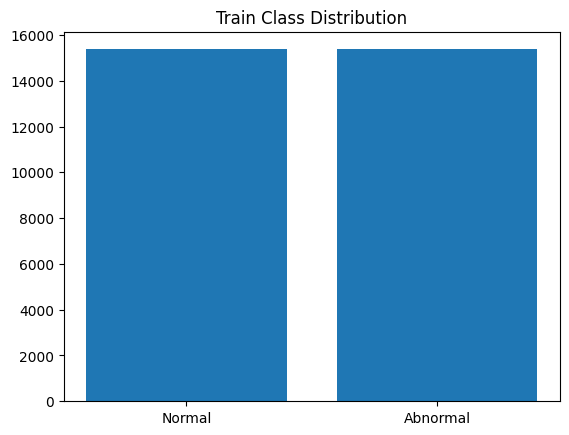

In [11]:
# Load and balance
X, y = load_data_binary_balanced(DATA_DIR, WINDOW, MIN_COUNT, SEED)
print("Class distribution after balancing:", np.bincount(y))

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=SEED, stratify=y
)
class_names = ['Normal','Abnormal']

# Optional: Visualize distribution
if plt is not None:
    u, c = np.unique(y_train, return_counts=True)
    plt.figure(); plt.bar(u, c, tick_label=[class_names[i] for i in u]); plt.title('Train Class Distribution'); plt.show()


In [12]:
class ECGDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].transpose(1,0), dtype=torch.float32)
        return x, torch.tensor(self.y[idx], dtype=torch.float32)

class Model(nn.Module):
    def __init__(self, window):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(8)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(16)
        fc_in    = (window // 2 // 2) * 16
        self.fc1   = nn.Linear(fc_in, 64)
        self.fc2   = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()  # Squeeze all trailing singleton dims

def train_epoch(model, loader, crit, opt, device):
    model.train()
    total_loss, total_n, correct = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        y = y.view(-1)
        opt.zero_grad()
        out = model(X)
        loss = crit(out, y)
        loss.backward(); opt.step()
        preds = (torch.sigmoid(out) > 0.5).float()
        total_loss += loss.item() * y.size(0)
        total_n    += y.size(0)
        correct    += (preds == y).sum().item()
    return total_loss/total_n, correct/total_n

def eval_epoch(model, loader, crit, device):
    model.eval()
    total_loss, total_n, correct = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y = y.view(-1)
            out = model(X)
            loss = crit(out, y)
            preds = (torch.sigmoid(out) > 0.5).float()
            total_loss += loss.item() * y.size(0)
            total_n    += y.size(0)
            correct    += (preds == y).sum().item()
    return total_loss/total_n, correct/total_n


In [13]:
def plot_history(history):
    if plt is None:
        print("Plot disabled: matplotlib unavailable.")
        return
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.title('Loss over Epochs'); plt.show()
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.title('Accuracy over Epochs'); plt.show()

def plot_confusion(y_true, y_pred, class_names):
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    if plt is None or sns is None:
        print("Confusion matrix plot disabled: matplotlib/seaborn unavailable.")
        return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

def plot_roc(model, loader, y_true, class_names, device):
    if plt is None:
        print("ROC plot disabled: matplotlib unavailable.")
        return
    model.eval()
    y_score = []
    with torch.no_grad():
        for X,_ in loader:
            X = X.to(device)
            logits = model(X).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            y_score.append(probs)
    y_score = np.concatenate(y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curve (Binary)'); plt.legend(loc='best'); plt.show()


▶ Epoch 1/20 | Train Loss: 0.1986, Train Acc: 0.9278 | Val Loss: 0.1293, Val Acc: 0.9572
▶ Epoch 2/20 | Train Loss: 0.1115, Train Acc: 0.9614 | Val Loss: 0.1021, Val Acc: 0.9639
▶ Epoch 3/20 | Train Loss: 0.0852, Train Acc: 0.9714 | Val Loss: 0.0904, Val Acc: 0.9691
▶ Epoch 4/20 | Train Loss: 0.0687, Train Acc: 0.9771 | Val Loss: 0.0715, Val Acc: 0.9759
▶ Epoch 5/20 | Train Loss: 0.0589, Train Acc: 0.9799 | Val Loss: 0.0779, Val Acc: 0.9736
▶ Epoch 6/20 | Train Loss: 0.0502, Train Acc: 0.9828 | Val Loss: 0.0703, Val Acc: 0.9777
▶ Epoch 7/20 | Train Loss: 0.0449, Train Acc: 0.9853 | Val Loss: 0.0625, Val Acc: 0.9801
▶ Epoch 8/20 | Train Loss: 0.0391, Train Acc: 0.9863 | Val Loss: 0.0596, Val Acc: 0.9814
▶ Epoch 9/20 | Train Loss: 0.0329, Train Acc: 0.9890 | Val Loss: 0.0621, Val Acc: 0.9806
▶ Epoch 10/20 | Train Loss: 0.0311, Train Acc: 0.9895 | Val Loss: 0.0660, Val Acc: 0.9792
▶ Epoch 11/20 | Train Loss: 0.0263, Train Acc: 0.9912 | Val Loss: 0.0644, Val Acc: 0.9793
▶ Epoch 12/20 | Tra

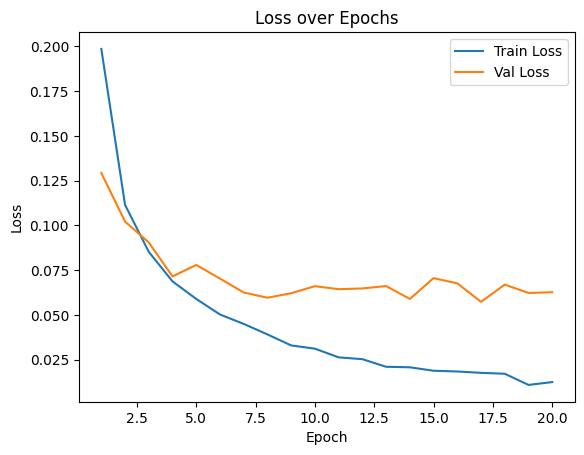

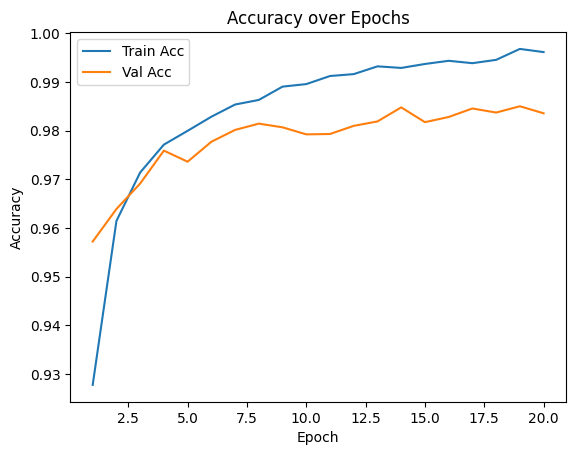

In [14]:
# Prepare loaders
train_ds = ECGDataset(X_train, y_train)
test_ds  = ECGDataset(X_test,  y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# Init model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Model(WINDOW).to(device)
crit   = nn.BCEWithLogitsLoss()
opt    = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
for ep in range(1, NUM_EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_epoch(model, test_loader, crit, device)
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"▶ Epoch {ep}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
plot_history(history)



Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      6589
    Abnormal       0.99      0.98      0.98      6589

    accuracy                           0.98     13178
   macro avg       0.98      0.98      0.98     13178
weighted avg       0.98      0.98      0.98     13178



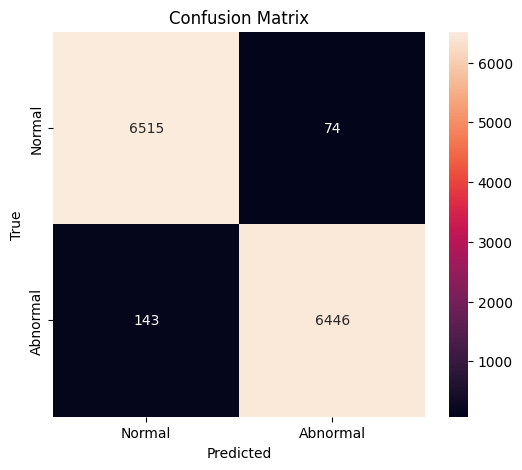

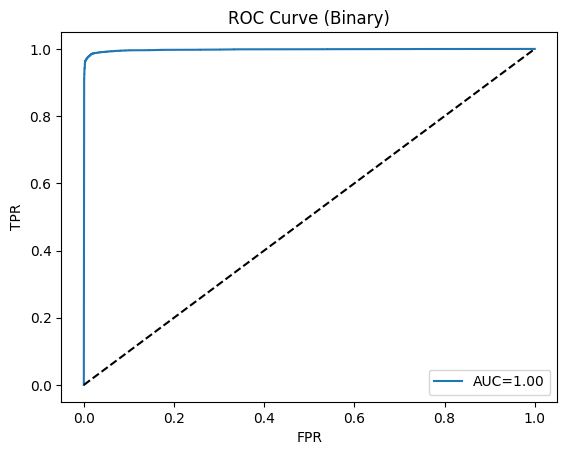

In [15]:
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        probs = torch.sigmoid(logits).cpu().numpy()
        test_preds.extend((probs > 0.5).astype(int))
        test_labels.extend(y.numpy())
plot_confusion(test_labels, test_preds, class_names)
plot_roc(model, test_loader, np.array(test_labels), class_names, device)


In [ ]:
# Save the model weights only (recommended for most workflows)
torch.save(model.state_dict(), "ecg_cnn_binary.pth")
print("✅ Model weights saved to ecg_cnn_binary.pth")
